In [73]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.api as sm2
import statistics as stat
import time
from numpy.random import normal
import seaborn as sns
import pylab
from scipy import optimize as opt
from scipy import stats as st
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA
from bisect import bisect_left
import timeit
import scipy 
import math
import pypfopt
from datetime import datetime
from risk_lib import VaR,ES,opt_port

# Problem 1

In [2]:
K=165
S=165
σ=0.2
r=0.0025
CR=0.0053
b=r-CR
T=(datetime(2022,4,15)-datetime(2022,3,13)).days/365


#Delta
def delta(S,K,T, σ,r,b,option):
    '''
    S: Underlying Price
    K: Strike Price
    T: Time to Maturity
    σ: implied volatility
    r: risk free rate
    b: cost of carry
    Φ (  ): Normal CDF Function
    option: option type
    '''
    d1=(np.log(S/K)+(b+σ**2/2)*T)/(σ*np.sqrt(T))
    if option =="c":
        delta=(np.exp(-CR*T))*st.norm.cdf(d1)
    elif option =="p":
        delta=(np.exp(-CR*T))*(st.norm.cdf(d1)-1)
    return delta

#Gamma
def gamma(S,K,T, σ,r,b,option):
    '''
    S: Underlying Price
    K: Strike Price
    T: Time to Maturity
    σ: implied volatility
    r: risk free rate
    b: cost of carry
    Φ (  ): Normal CDF Function
    option: option type
    '''
    d1=(np.log(S/K)+(b+σ**2/2)*T)/(σ*np.sqrt(T))
    d2=d1-σ*np.sqrt(T)
    gamma=(np.exp(-CR*T))*st.norm.pdf(d1,0,1)/(S*σ*np.sqrt(T))
    return gamma

#vega
def vega(S,K,T, σ,r,b,option):
    '''
    S: Underlying Price
    K: Strike Price
    T: Time to Maturity
    σ: implied volatility
    r: risk free rate
    b: cost of carry
    Φ (  ): Normal CDF Function
    option: option type
    '''
    d1=(np.log(S/K)+(b+σ**2/2)*T)/(σ*np.sqrt(T))
    d2=d1-σ*np.sqrt(T)
    vega=(np.exp(-CR*T))*S*st.norm.pdf(d1,0,1)*np.sqrt(T)
    return vega

#Theta
def Theta(S,K,T, σ,r,b,option):
    '''
    S: Underlying Price
    K: Strike Price
    T: Time to Maturity
    σ: implied volatility
    r: risk free rate
    b: cost of carry
    Φ (  ): Normal CDF Function
    option: option type
    '''
    d1=(np.log(S/K)+(b+σ**2/2)*T)/(σ*np.sqrt(T))
    d2=d1-σ*np.sqrt(T)
    
    if option =="c":
        Theta=- (S * np.exp((b-r) * T) * st.norm.pdf(d1) * σ) / (2 * np.sqrt(T)) \
                - (b-r) * S * np.exp((b-r) * T) * st.norm.cdf(d1) \
                - r * K * np.exp(-r * T) * st.norm.cdf(d2)
    elif option=="p":
        Theta=- (S * np.exp((b-r) * T) * st.norm.pdf(d1) * σ) / (2 * np.sqrt(T)) \
                + (b-r) * S * np.exp((b-r) * T) * st.norm.cdf(-d1) \
                + r * K * np.exp(-r * T) * st.norm.cdf(-d2)
    return Theta

#rho
def rho(S,K,T, σ,r,b,option):
    d1=(np.log(S/K)+(b+σ**2/2)*T)/(σ*np.sqrt(T))
    d2=d1-σ*np.sqrt(T)
    
    if option =="c":
        rho=np.exp(-r*T)*T*K*st.norm.cdf(d2)
        return rho
        
    elif option=="p":
        rho=-np.exp(-r*T)*T*K*st.norm.cdf(-d2)
        return rho
    
#carry rho
def c_rho(S,K,T, σ,r,b,option):
    d1=(np.log(S/K)+(b+σ**2/2)*T)/(σ*np.sqrt(T))
    d2=d1-σ*np.sqrt(T)
    if option =="c":
        c_rho=-np.exp(-CR*T)*T*S*st.norm.cdf(d1)
        return c_rho
    
    elif option=="p":
        c_rho=np.exp(-CR*T)*T*S*st.norm.cdf(-d1)
        return c_rho


In [3]:
def black_scholes(S,K,T,r,CR,σ,option):
    d1 = (np.log(S/K)+(r-CR+σ**2/2)*T)/(σ*np.sqrt(T))
    d2 = d1-σ*np.sqrt(T)
    if option=="c":
        return S*np.exp(-CR*T)*st.norm.cdf(d1)-K*np.exp(-r*T)*st.norm.cdf(d2)
    elif option=="p":
        return K*np.exp(-r*T)*st.norm.cdf(-d2)-S*np.exp(-CR*T)*st.norm.cdf(-d1)

In [4]:

def d_delta(S,K,T,r,CR,σ,option, ds = 0.01):
    u = black_scholes(S+ds, K, T, r, CR, σ,option)
    d = black_scholes(S-ds, K, T, r, CR, σ, option)
    return (u-d)/2/ds

def d_gamma(S,K,T,r,CR,σ,option, ds = 0.01):
    u = black_scholes(S+ds, K, T, r, CR, σ, option)
    m = black_scholes(S, K, T, r, CR, σ, option)
    d = black_scholes(S-ds, K, T, r, CR, σ, option)
    return (u-2*m+d)/2/ds/ds
        
def d_vega(S,K,T,r,CR,σ,option, dsig = 0.001):
    u = black_scholes(S, K, T, r, CR, σ+dsig, option)
    d = black_scholes(S, K, T, r, CR, σ-dsig, option)
    return (u-d)/2/dsig
        
def d_theta(S,K,T,r,CR,σ,option, dt = 0.001):
    u = black_scholes(S, K, T-dt, r, CR, σ, option)
    d = black_scholes(S, K, T+dt, r, CR, σ, option)
    return (u-d)/2/dt
    
def d_rho(S,K,T,r,CR,σ,option, dr = 0.001):
    u = black_scholes(S, K, T, r+dr, CR,σ , option)
    d = black_scholes(S, K, T, r-dr, CR,σ , option)
    return (u-d)/2/dr
    
def d_c_rho(S,K,T,r,CR,σ,option, db = 0.001):
    u = black_scholes(S, K, T, r, CR+db,σ , option)
    d = black_scholes(S, K, T, r, CR-db,σ , option)
    return (u-d)/2/db



d_call = pd.DataFrame(np.array([d_delta(S,K,T,r,CR,σ,"c"), d_gamma(S,K,T,r,CR,σ,"c"), d_vega(S,K,T,r,CR,σ,"c"), d_theta(S,K,T,r,CR,σ,"c"), d_rho(S,K,T,r,CR,σ,"c"), d_c_rho(S,K,T,r,CR,σ,"c")]),index=['delta','gamma','vega','theta','rho','carry rho'])
d_put=pd.DataFrame(np.array([d_delta(S,K,T,r,CR,σ,"p"), d_gamma(S,K,T,r,CR,σ,"p"), d_vega(S,K,T,r,CR,σ,"p"), d_theta(S,K,T,r,CR,σ,"p"), d_rho(S,K,T,r,CR,σ,"p"), d_c_rho(S,K,T,r,CR,σ,"p")]),index=['delta','gamma','vega','theta','rho','carry rho'])
call=pd.DataFrame(np.array([delta(S,K,T, σ,r,b,"c"), gamma(S,K,T, σ,r,b,"c"), vega(S,K,T, σ,r,b,"c"), Theta(S,K,T, σ,r,b,"c"), rho(S,K,T, σ,r,b,"c"), c_rho(S,K,T, σ,r,b,"c")]),index=['delta','gamma','vega','theta','rho','carry rho'])
put=pd.DataFrame(np.array([delta(S,K,T, σ,r,b,"p"), gamma(S,K,T, σ,r,b,"p"), vega(S,K,T, σ,r,b,"p"), Theta(S,K,T, σ,r,b,"p"), rho(S,K,T, σ,r,b,"p"), c_rho(S,K,T, σ,r,b,"p")]),index=['delta','gamma','vega','theta','rho','carry rho'])
chart=pd.concat([call,put,d_call,d_put],axis=1)
chart=chart.set_axis(["GBSM Call","GBSM Put","Diff Call","Diff Put"], axis=1) 
chart

,GBSM Call,GBSM Put,Diff Call,Diff Put
delta,0.510071,-0.489450,0.510071,-0.489450
gamma,0.040173,0.040173,0.020086,0.020086
vega,19.776582,19.776582,19.776582,19.776582
theta,-21.628607,-22.090281,-21.628942,-22.090616
rho,7.253304,-7.661132,7.253304,-7.661133
carry rho,-7.609135,7.301527,-7.609135,7.301527


In [5]:
def BinomialTree(Otype,S0, K, r, sigma, T, N=2000,american='false',divi=[[],[]]):
    def expiCall(stock,strike):
        return(np.maximum(stock-strike,0))
    
    def expiPut(stock,strike):
        return(np.maximum(strike-stock,0))
    
    def earlyCall(Option,stock,strike):
        return(np.maximum(stock-strike,Option))
    
    def earlyEuro(Option,stock,strike):
        return(np.maximum(Option,0))
    
    def earlyPut(Option,stock,strike):
        return(np.maximum(strike-stock,Option))    
  
    if Otype=='C':
        expi=expiCall
        early=earlyCall
    else:
        expi=expiPut   
        early=earlyPut
    
    if american=='false':
        early=earlyEuro
     
    deltaT = float(T) / N
    dividends=[[],[]]

    if (np.size(divi)>0 and divi[0][0]<T) :
        lastdiv=np.nonzero(np.array(divi[0][:])<=T)[0][-1]
        dividends[0]=divi[0][:lastdiv+1]        
        dividends[1]=divi[1][:lastdiv+1] 
      
    if np.size(dividends)>0:
        dividendsStep=np.floor(np.multiply(dividends[0],1/deltaT))
    else:
        dividendsStep=[]    
        
    if np.size(dividends)>0:
        pvdividends=np.sum(np.multiply(dividends[1],np.exp(np.multiply(dividendsStep,-r*deltaT))))
    else:
        pvdividends=0

    S0=S0-pvdividends
    currentDividend=0
    u = np.exp(sigma * np.sqrt(deltaT))
    d = 1.0 / u
    fs =  np.asarray([0.0 for i in range(N + 1)])
    fs2 = np.asarray([(S0 * u**j * d**(N - j)) for j in range(N + 1)])
    fs3 =np.asarray( [float(K) for i in range(N + 1)])
    a = np.exp(r * deltaT)
    p = (a - d)/ (u - d)
    oneMinusP = 1.0 - p
    fs[:] = expi(fs2,fs3)
    for i in range(N-1, -1, -1):
        fs[:-1]=np.exp(-r * deltaT) * (p * fs[1:] + oneMinusP * fs[:-1])
        fs2[:]=fs2[:]*u
        currentDividend=currentDividend/a
        if (i in dividendsStep):
            div=dividends[1]
            div = div[np.nonzero(dividendsStep==(i))[0][0]]  
            currentDividend=currentDividend+div

        fs[:]=early(fs[:],fs2[:]+currentDividend,fs3[:])
                
    return fs[0]

def n_delta(Option,S0, K, r, σ, T, N=2000,american='false',divi=[[],[]], ds = 0.01):
    u = BinomialTree(Option, S0+ds, K, r, σ, T, N,american, divi)
    d = BinomialTree(Option, S0-ds, K, r, σ, T, N,american, divi)
    return 0.5*(u-d)/ds
        
def n_gamma(Option,S0, K, r, σ, T, N=2000,american='false',divi=[[],[]],ds = 1):
    u = BinomialTree(Option, S0+ds, K, r, σ, T, N,american, divi)
    m = BinomialTree(Option, S0, K, r, σ, T, N,american, divi)
    d = BinomialTree(Option, S0-ds, K, r, σ, T, N,american, divi)
    return (u-2*m+d)/ds/ds
        
def n_vega(Option,S0, K, r, σ, T, N=2000,american='false',divi=[[],[]], dsig = 0.001):
    u = BinomialTree(Option, S0, K, r, σ+dsig, T, N,american, divi)
    d = BinomialTree(Option, S0, K, r, σ-dsig, T, N,american, divi)
    return 0.5*(u-d)/dsig
        
def n_theta(Option,S0, K, r, σ, T, N=2000,american='false',divi=[[],[]], dt = 0.001):
    u = BinomialTree(Option, S0, K, r, σ, T-dt, N,american, divi)
    d = BinomialTree(Option, S0, K, r, σ, T+dt, N,american, divi)
    return 0.5*(u-d)/dt
    
def n_rho(Option,S0, K, r, σ, T, N=2000,american='false',divi=[[],[]], dr = 0.001):
    u = BinomialTree(Option, S0, K, r+dr, σ, T, N,american, divi)
    d = BinomialTree(Option, S0, K, r-dr, σ, T, N,american, divi)
    return 0.5*(u-d)/dr
    
def n_c_roh(Option,S0, K, r, σ, T, N=2000,american='false',divi=[[],[]], ddiv = 0.001):
    div_u = [[DivTime],[1+ddiv]]
    div_d = [[DivTime],[1-ddiv]]
    u = BinomialTree(Option, S0, K, r, σ, T, N,american, div_u)
    d = BinomialTree(Option, S0, K, r, σ, T, N,american, div_d)
    return 0.5*(u-d)/ddiv

def greek(self):
    opt = 'Call' if self.Otype=='C' else 'Put'
    greek_frame = pd.DataFrame(np.array([self.Delta, self.Gamma, self.Vega, self.Theta, self.Rho, self.Phi]),index=['delta','gamma','vega','theta','rho','dividen sensitivity'],columns=['Binomial Tree '+opt])
    return greek_frame

In [6]:
DivTime = (datetime(2022,4,11)-datetime(2022,3,13)).days/365
div=[[DivTime],[1]]
n_delta('C', 165, 165, r,  σ, T, 2000,'true', div)
bt_call=pd.DataFrame(np.array([n_delta('C', 165, 165, r,  σ, T, 2000,'true', div), n_gamma('C', 165, 165, r,  σ, T, 2000,'true', div), n_vega('C', 165, 165, r,  σ, T, 2000,'true', div), n_theta('C', 165, 165, r,  σ, T, 2000,'true', div), n_rho('C', 165, 165, r,  σ, T, 2000,'true', div), n_c_roh('C', 165, 165, r,  σ, T, 2000,'true', div)]),index=['delta','gamma','vega','theta','rho','carry rho'])
bt_put=pd.DataFrame(np.array([n_delta('P', 165, 165, r,  σ, T, 2000,'true', div), n_gamma('P', 165, 165, r,  σ, T, 2000,'true', div), n_vega('P', 165, 165, r,  σ, T, 2000,'true', div), n_theta('P', 165, 165, r,  σ, T, 2000,'true', div), n_rho('P', 165, 165, r,  σ, T, 2000,'true', div), n_c_roh('P', 165, 165, r,  σ, T, 2000,'true', div)]),index=['delta','gamma','vega','theta','rho','carry rho'])
bt_chart=pd.concat([bt_call,bt_put],axis=1)
bt_chart=bt_chart.set_axis(["BT_Call","BT_Put"], axis=1)
bt_chart



,BT_Call,BT_Put
delta,0.510500,-0.531187
gamma,0.041285,0.039790
vega,19.349184,19.607574
theta,-13.425310,-21.528016
rho,6.538935,-7.746206
carry rho,-0.095796,0.531082


In [7]:
print("call price:",np.round(BinomialTree('C', 165, 165, r, σ, T, 2000, 'true', div),4))
print("put price:", np.round(BinomialTree('P', 165, 165, r, σ, T, 2000, 'true', div),4))

call price: 3.8147
put price: 4.4469


# Problem 2

In [57]:
S = 164.85
DivTime = ((datetime(2022,3,15)-datetime(2022,2,25)).days)/365
r = 0.0025
portfolio= pd.read_csv('https://raw.githubusercontent.com/dompazz/FinTech590-RiskManagement/main/Week07/Project/problem2.csv')


In [9]:
returns = pd.read_csv('https://raw.githubusercontent.com/dompazz/FinTech590-RiskManagement/main/Week07/Project/DailyReturn.csv',index_col = 0)
AAPL_returns = returns['AAPL']
AApl_Sig = AAPL_returns .std()


In [10]:
def modified_black_scholes(S,K,T,r,CR,σ,option):
    d1 = (np.log(S/K)+(r-CR+σ**2/2)*T)/(σ*np.sqrt(T))
    d2 = d1-σ*np.sqrt(T)
    if option==True:
        return S*np.exp(-CR*T)*st.norm.cdf(d1)-K*np.exp(-r*T)*st.norm.cdf(d2)
    elif option==False:
        return K*np.exp(-r*T)*st.norm.cdf(-d2)-S*np.exp(-CR*T)*st.norm.cdf(-d1)

def implied_volatility(S,K,T,r,q,opt_price,opt=True):
    volatility = lambda x: modified_black_scholes(S,K,T,r,q,x,opt) - opt_price
    return scipy.optimize.fsolve(volatility, x0 = 0.5)[0]

In [11]:
K = portfolio['Strike']
TTM = (datetime(2022,3,18) - datetime(2022,2,25)).days/365
option_T = np.where((portfolio['OptionType'] == "Call"), True, np.where((portfolio['OptionType'] == "Put"), False, np.nan))
opt_price = portfolio['CurrentPrice']
Grad = []
PV = []
implied_vol = []
ptwo_Delta = []
mean = []
var = []
es = []


for i in range(len(K)):
    if portfolio['Type'][i]=='Option':
        implied_vol.append(implied_volatility(S,K[i],TTM,r,CR,opt_price[i],option_T[i]))
        if portfolio['OptionType'][i]=="Call":
             opt='C'
        else:
            opt='P'
        div = [[DivTime],[0.88]]
        ptwo_Delta.append(n_delta(opt, 164.85, portfolio['Strike'][i], r, σ, TTM, 2000,'true', div))
    else:
        implied_vol.append(np.nan)
        ptwo_Delta.append(1)
portfolio['Delta'] = np.array(ptwo_Delta)
portfolio['Implied_vol'] = np.array(implied_vol)









Strategy = portfolio['Portfolio'].unique()


for i in range(len(Strategy)):
    data = portfolio[portfolio['Portfolio']==Strategy[i]] 
    pv = (data['CurrentPrice']*data['Holding']).sum()
    PV.append(pv)
    grad = S/pv * (data['Holding']*portfolio['Delta']).sum()
    Grad.append(grad)

portSigma = []
for grad in Grad:
    portSigma.append(np.abs(grad)*AApl_Sig)

rets_sim = pd.DataFrame()
for i in range(len(portSigma)):
    return_simu = st.norm.rvs(size = 10000, loc=0, scale = portSigma[i]*np.sqrt(10))
    rets_sim[Strategy[i]] = return_simu
    


for i in range(len(Strategy)):
    sim_PnL = PV[i]*(rets_sim[Strategy[i]])
    
    mean.append(sim_PnL.mean())
    var.append(VaR.VaR_His(sim_PnL,0.05))
    es.append(ES.ES(sim_PnL,0.05))

con=pd.DataFrame({"Mean":mean,'VaR':var,'ES':es},index =Strategy)
con




,Mean,VaR,ES
Straddle,-0.001132,0.352680,0.443069
SynLong,-0.157994,14.306649,18.006096
CallSpread,-0.058385,5.720999,7.185236
PutSpread,-0.033005,5.786944,7.324354
Stock,0.071415,13.807575,17.243783
Call,0.011783,6.984836,8.769923
Put,0.021688,7.210895,9.182344
CoveredCall,0.091827,6.498812,8.182509
ProtectedPut,0.012835,6.389496,7.965610


# Problem 3:


In [47]:
# Problem 3
rets = pd.read_csv('https://raw.githubusercontent.com/dompazz/FinTech590-RiskManagement/main/Week07/Project/DailyReturn.csv')
ffr = pd.read_csv("https://raw.githubusercontent.com/dompazz/FinTech590-RiskManagement/main/Week07/Project/F-F_Research_Data_Factors_daily.CSV")
momentum = pd.read_csv('https://raw.githubusercontent.com/dompazz/FinTech590-RiskManagement/main/Week07/Project/F-F_Momentum_Factor_daily.CSV')

In [48]:
exp_rets = []
momentum.columns = ['Date', 'MOM']
ffr.columns = ["Date", "Mkt_RF", "SMB", "HML", "RF"]
ff = pd.merge(ffr, momentum, on="Date")
ff['Date'] = pd.to_datetime(ff['Date'], format="%Y%m%d")
ff = ff[ff['Date'] > "2012-01-01"].reset_index(drop=True)
ff[["Mkt_RF", "SMB", "HML", "MOM", "RF"]] = ff[["Mkt_RF", "SMB", "HML", "MOM", "RF"]] / 100
rets['Date'] = pd.to_datetime(rets['Date'])
rets = (pd.merge(rets, ff, on="Date")).rename(columns={"BRK-B": "BRK_B"})

stocklist = ['AAPL', 'FB', 'UNH', 'MA', 'MSFT', 'NVDA', 'HD', 'PFE', 'AMZN', 'BRK_B','PG', 'XOM', 'TSLA', 'JPM', 'V', 'DIS', 'GOOGL', 'JNJ', 'BAC', 'CSCO']
params = []
for stock in stocklist:
    rets[stock] = rets[stock] - rets['RF']
    output = sm.ols(formula=stock + "~Mkt_RF + SMB + HML + MOM", data=rets).fit()
    params.append(output.params[1:])


exp_rf = ff['RF'].mean()
exp_factors = ff[["Mkt_RF", "SMB", "HML", "MOM"]].mean(axis=0)
covariance = (np.log(rets[stocklist] + 1)).cov() * 255
expReturns = pd.DataFrame()
expReturns['stock'] = stocklist
for i in range(len(params)):
    exp_rets.append((np.log((params[i] * exp_factors).sum() + 1) + exp_rf) * 255)
expReturns['expected_annual_return'] = exp_rets
covariance


,AAPL,FB,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK_B,PG,XOM,TSLA,JPM,V,DIS,GOOGL,JNJ,BAC,CSCO
AAPL,0.065441,0.031073,0.020744,0.010865,0.039993,0.081306,0.020419,-0.021341,0.041714,0.000136,-0.002699,0.008210,0.081903,0.005251,0.010712,0.012826,0.031423,-0.003238,0.005305,0.011880
FB,0.031073,0.104613,0.008503,0.040435,0.037940,0.071235,0.007342,-0.034076,0.039219,0.009335,0.000548,0.016634,0.070407,0.003429,0.034626,0.029683,0.036417,0.005036,0.008607,0.016598
UNH,0.020744,0.008503,0.044678,0.025495,0.022884,0.037212,0.016155,-0.006501,0.018861,0.002269,0.011324,0.009566,0.024662,0.003660,0.018395,0.010282,0.021946,0.008787,0.003671,0.015559
MA,0.010865,0.040435,0.025495,0.129913,0.008331,0.032840,0.013766,-0.025942,0.018757,0.020274,0.012592,0.047964,0.042987,0.027444,0.098294,0.044054,0.010899,0.013416,0.040533,0.017995
MSFT,0.039993,0.037940,0.022884,0.008331,0.065237,0.089283,0.022864,-0.018821,0.033346,-0.001568,0.002797,0.004023,0.078434,-0.003993,0.003577,0.010030,0.051307,-0.001555,-0.000343,0.022863
NVDA,0.081306,0.071235,0.037212,0.032840,0.089283,0.354876,0.052871,-0.048652,0.100484,-0.003756,-0.009097,0.033804,0.188497,0.007134,0.041099,0.023697,0.083843,-0.013139,0.017036,0.013277
HD,0.020419,0.007342,0.016155,0.013766,0.022864,0.052871,0.058241,-0.022702,0.014528,0.000238,0.006162,0.005143,0.028978,0.014535,0.013316,0.011541,0.022639,0.002178,0.007904,0.003715
PFE,-0.021341,-0.034076,-0.006501,-0.025942,-0.018821,-0.048652,-0.022702,0.177019,-0.027410,-0.012057,0.005692,-0.036887,-0.055088,-0.022267,-0.015947,-0.023313,-0.021314,0.006779,-0.034283,-0.002152
AMZN,0.041714,0.039219,0.018861,0.018757,0.033346,0.100484,0.014528,-0.027410,0.066280,-0.001549,-0.003372,0.013645,0.041839,-0.001034,0.010257,0.017323,0.039699,-0.003340,0.002833,0.002798
BRK_B,0.000136,0.009335,0.002269,0.020274,-0.001568,-0.003756,0.000238,-0.012057,-0.001549,0.022978,0.009790,0.023074,-0.005053,0.022736,0.018162,0.010155,0.001378,0.009128,0.028815,0.007915


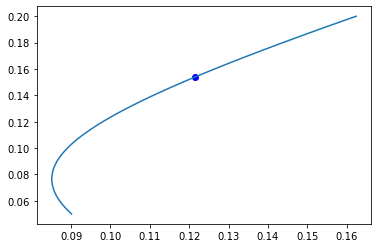

In [79]:
risk = opt_port.getrisk(exp_rets, covariance, np.arange(0.05, 0.20, 0.002))
SR, Idx = opt_port.eff(np.arange(0.05, 0.20, 0.002), riskVars, 0.0025)
plt.plot(risk[Idx], np.arange(0.05, 0.20, 0.002)[Idx], 'bo')
plt.plot(risk, targetReturns)
plt.show()


